In [59]:
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
# state-level natural gas prices
state_ng = pd.read_excel('./input_data/ng_prices_state_annual_us.xlsx', sheet_name='clean_data_2022', header=0 ).transpose()
state_ng.reset_index(inplace=True)
state_ng.rename(columns={0:'NG price ($/MMBtu)', 'index':'state'}, inplace=True)
state_ng['state'] = state_ng.apply(lambda x:x['state'].split(' Natural')[0], axis=1)
state_ng.set_index('state', inplace=True)

In [61]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
abbrev_states = pd.DataFrame(us_state_to_abbrev.items(), columns=['state', 'abbrev'])

abbrev_states.set_index('state', inplace=True)
state_ng = state_ng.merge(abbrev_states, on='state')
state_ng.reset_index(inplace=True)
state_ng

,state,NG price ($/MMBtu),abbrev
0,Alabama,7.87,AL
1,Alaska,6.72,AK
2,Arizona,7.48,AZ
3,Arkansas,10.46,AR
4,California,13.73,CA
5,Colorado,10.12,CO
6,Connecticut,10.37,CT
7,Delaware,12.05,DE
8,Florida,9.38,FL
9,Georgia,9.02,GA


In [62]:
ammonia = pd.read_csv('./results/ammonia_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
heat = pd.read_csv('./results/process_heat_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
refining = pd.read_csv('./results/refining_anr_lr_0_h2_lr_0_wacc_0.077_clean.csv')
ammonia = ammonia[['state', 'Breakeven NG price ($/MMBtu)']]
ammonia['Industry'] = 'Ammonia'
heat = heat[['state', 'Breakeven NG price ($/MMBtu)']]
heat['Industry'] = 'Process heat'



In [63]:
refining = refining[['state', 'Breakeven price ($/MMBtu)']]
abbrev_states.reset_index(inplace=True)
abbrev_states['state'] = abbrev_states.apply(lambda x:x['state'].upper(), axis=1)
refining = refining.merge(abbrev_states,left_on='state', right_on='state')
refining['Industry'] = 'Refining'
refining.drop(columns=['state'], inplace=True)
refining.rename(columns={'Breakeven price ($/MMBtu)':'Breakeven NG price ($/MMBtu)', \
                         'abbrev':'state'}, inplace=True)


In [64]:
total = pd.concat([ammonia, heat, refining], ignore_index=True)
total

,state,Breakeven NG price ($/MMBtu),Industry
0,LA,26.7,Ammonia
1,OK,26.8,Ammonia
2,OK,27.3,Ammonia
3,AK,27.3,Ammonia
4,GA,27.5,Ammonia
...,...,...,...
369,AR,24.1,Refining
370,AR,39.2,Refining
371,HI,26.1,Refining
372,PA,30.2,Refining


In [65]:
total_with_ng = total.merge(state_ng, left_on='state', right_on='abbrev')
total_with_ng.rename(columns={'NG price ($/MMBtu)':'State-level industrial NG price ($/MMBtu)'}, inplace=True)

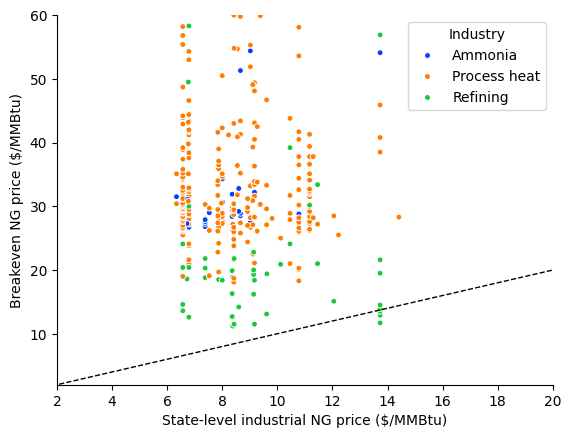

In [66]:
# plot
import seaborn as sns
import numpy as np
ax = sns.scatterplot(data=total_with_ng, x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)', hue='Industry', palette='bright', marker='.', s=70)
ax.set_ylim(2,60)
ax.set_xlim(2,20)
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, color='k', linestyle='--', linewidth=1, label='No CO2 tax')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('./results/be_ng_state.png')

In [67]:
carbon_prices = [230, 270, 310] #$/tCO2 for 2030, 2040, 2050
h2_ptc = 3 #$/kgH2 clean
elec_ptc = 25 #$/MWhe
avg_elec_cons_h2 = 0.022 #MWhe/kgh2, calculated from avg thermal efficiency (micro, PBR-HTGR, iMSR) and coupling efficiency with HTSE

# NH3
nh3_carbon_intensity = 2.30 # tcO2/tNH3
nh3_nrj_intensity = 30.82 #MMBtu/tNH3
nh3_h2_intensity = 507.71 # kgh2/tNH3
nh3_carbon_prices = [c*nh3_carbon_intensity/nh3_nrj_intensity for c in carbon_prices]
nh3_h2_ptc = h2_ptc*nh3_h2_intensity/nh3_nrj_intensity
nh3_elec_ptc = elec_ptc*avg_elec_cons_h2*nh3_h2_intensity/nh3_nrj_intensity

# Refining
smr_carbon_intensity = 11.888 #kgCO2/kgh2
smr_nrj_intensity = 0.1578 # MMBtu/kgh2
refining_carbon_prices = [c*smr_carbon_intensity/1e3 for c in carbon_prices]
refining_h2_ptc = h2_ptc/smr_nrj_intensity
refining_elec_ptc = elec_ptc*avg_elec_cons_h2/smr_nrj_intensity

# Process heat
heat_avg_carbon_intensity = 0.002028 #tCO2/MMBtu
h2_hhv = 141.88 # MJ/kgh2
mmbtu_to_mj = 1055.06 #mj/MmBtu
heat_carbon_prices = [c*heat_avg_carbon_intensity for c in carbon_prices]
heat_h2_ptc = h2_ptc*mmbtu_to_mj/h2_hhv
heat_elec_ptc = elec_ptc*avg_elec_cons_h2*mmbtu_to_mj/h2_hhv



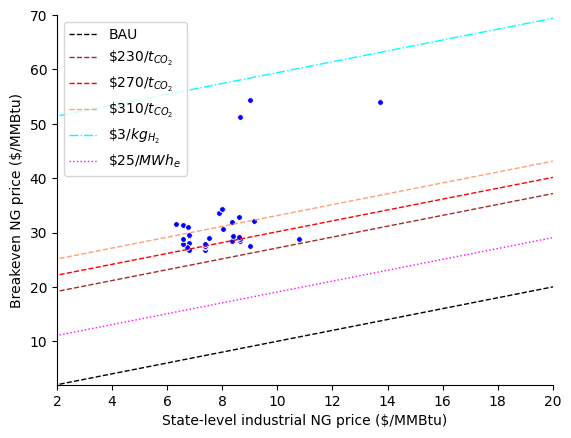

In [85]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Ammonia'], x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)',color='b', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+nh3_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+nh3_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+nh3_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+nh3_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+nh3_elec_ptc for x in med_x]
ax.plot(med_x, elec, color='magenta', linestyle='dotted', linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/ammonia_be_state_with_carbon_prices.png')

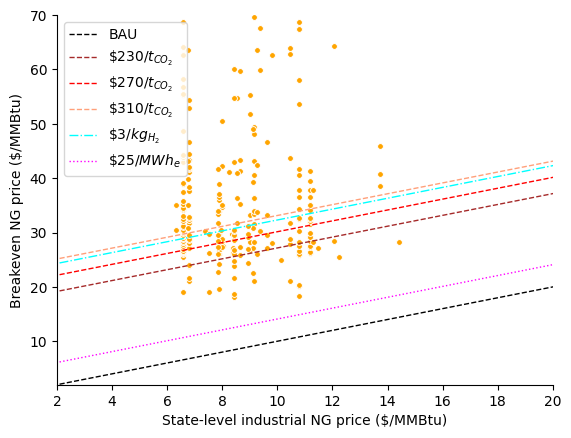

In [84]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Process heat'], x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)',color='orange', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+nh3_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+nh3_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+nh3_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+heat_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+heat_elec_ptc for x in med_x]
ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')



ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/process_heat_be_state_with_carbon_prices.png')

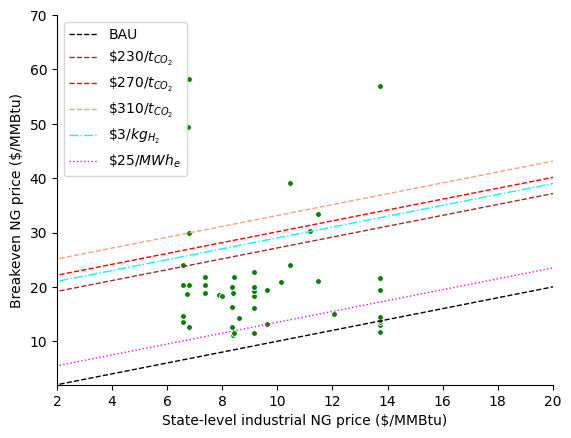

In [83]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Refining'], x='State-level industrial NG price ($/MMBtu)',\
                     y='Breakeven NG price ($/MMBtu)',color='g', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+nh3_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+nh3_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+nh3_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+refining_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+refining_elec_ptc for x in med_x]
ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/refining_be_state_with_carbon_prices.png')